In [1]:
import quik_ai as qa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib.metadata import version 
print('Quik-AI Version: %s' % version('quik_ai'))

Quik-AI Version: 1.1.0


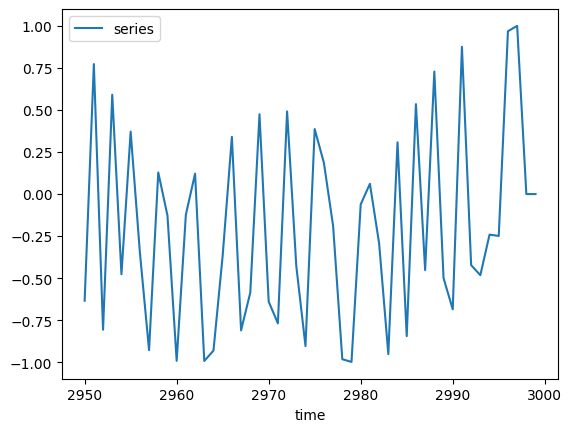

In [2]:
# build univariate time-series data by combining random frequencies
np.random.seed(123)

# creating the dataframes
domain = np.linspace(0, 80 * np.pi, 1000)
df1 = pd.DataFrame({'value': np.sin(domain), 'func': 'sin'})
df2 = pd.DataFrame({'value': np.cos(domain), 'func': 'cos'})
df3 = pd.DataFrame({'value': np.sin(domain)*np.cos(domain), 'func': 'sincos'})

# resetting the index to create an auxiliary column for each dataframe
df1 = df1.reset_index()
df2 = df2.reset_index()
df3 = df3.reset_index()

# concatenating the dataframes
data = pd.concat([df1, df2, df3])

# Sorting by the auxiliary index and then removing the auxiliary column
data = data.sort_values(by='index').reset_index(drop=True)
data = data.drop(columns='index')

# plot the two time-series
cnt = 50
plt.plot(data.index[-cnt:], data.tail(cnt).value, label='series');
plt.xlabel('time');
plt.legend();

In [3]:
# split the data
training_data, validation_data, test_data = qa.train_val_test_split(data)

# create the driver, this will generate the tensorflow dataset and feed data
driver = qa.Driver(training_data, validation_data, test_data, time_group_column='func')

# what does our response look like?
head = qa.heads.Regression()

# all the predictors for the model, in this case we only have one
# we will mask out the value in the current row while looking at
# the prior data
predictors = [
    qa.predictors.TimeMasked('value'),
]

# what is our model architecture? This will store
# our model, driver, and any other information we use in training
# testing, saving, and loading needed for this problem
model = qa.models.RNN('value', head, predictors, driver, time_window=32)

# train the model, we can provide a hyperparameter tuner and other
# training parameters, by default we will use a custom BOHB tuner
model.train(qa.tuners.TunerContainer(qa.tuners.BOHB, max_epochs=10))

Trial 30 Complete [00h 00m 11s]
val_mean_squared_error: 0.014435507357120514

Best val_mean_squared_error So Far: 0.01328066922724247
Total elapsed time: 00h 03m 20s
INFO:tensorflow:Oracle triggered exit
Round 1 best score: 0.0039


In [4]:
# evaluate the model on test data
model.evaluate()

3/3 [==============================] - 2s 730ms/step - loss: 0.0065 - mean_squared_error: 0.0065


{'loss': 0.006540360860526562, 'mean_squared_error': 0.006540360860526562}

In [5]:
# save the model to disk and reload the model
# then test on the test data once again
model.save()
model = qa.HyperModel.load()

# evaluate again, this should be the same score as before
model.evaluate()

INFO:tensorflow:Assets written to: ./model\tf_model\assets
3/3 [==============================] - 0s 25ms/step - loss: 0.0065 - mean_squared_error: 0.0065


{'loss': 0.006540360860526562, 'mean_squared_error': 0.006540360860526562}

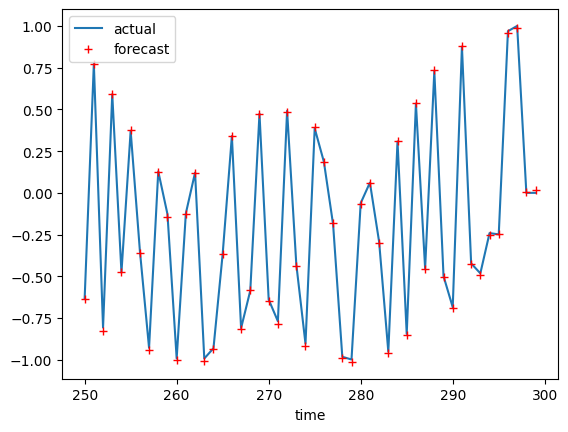

In [6]:
# get predictions on the test
predictions = model.predict(test_data, verbose=0)

# get actuals
actuals = test_data.value

# plot the predictions vs forecast
plt.plot(test_data.index[-cnt:], actuals.tail(cnt), label='actual');
plt.plot(test_data.index[-cnt:], predictions[-cnt:], 'r+', label='forecast');
plt.xlabel('time')
plt.legend();